## Loading data with yt_xarray 

This notebook demonstrates how to initialize a yt dataset object from an open xarray dataset.

After describing the sample data that is used, the notebook covers:

* [Loading all fields](#Loading-all-fields)
* [Overview of yt datasets](#A-brief-overview-of-yt-datasets)
* [Loading a subset of fields](#Loading-a-subset-of-fields)
* [Loading method and memory usage](#Loading-method-and-memory-usage)


### sample data

We'll be using some random sample data in this notebook (as well as many of the others), generated from a convenience function, `yt_xarray.sample_data.load_random_xr_data()`. To use it, we have to supply two dictionaries: one containing fieldnames mapped to the dimension names and a second containing the starting value, end value and number of elements for each dimension:




In [1]:
from yt_xarray.sample_data import load_random_xr_data

fields = {'temperature': ('x', 'y', 'z'), 'pressure': ('x', 'y', 'z')}
dims = {'x': (0,1,15), 'y': (0, 1, 10), 'z': (0, 1, 15)}
ds = load_random_xr_data(fields, dims, length_unit='m')
ds

<xarray.Dataset>
Dimensions:      (x: 15, y: 10, z: 15)
Coordinates:
  * x            (x) float64 0.0 0.07143 0.1429 0.2143 ... 0.8571 0.9286 1.0
  * y            (y) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * z            (z) float64 0.0 0.07143 0.1429 0.2143 ... 0.8571 0.9286 1.0
Data variables:
    temperature  (x, y, z) float64 0.1949 0.9943 0.06606 ... 0.3274 0.4862
    pressure     (x, y, z) float64 0.4819 0.6646 0.1181 ... 0.4984 0.2405 0.6845
Attributes:
    geospatial_vertical_units:  m

While we're using random sample data here, note that yt_xarray provides a simple wrapper of the standard xarray `open_dataset` function that will check yt's `test_data_dir` for data if the file is not found in the local path. It is used in the same way as xarray:

```python
ds = yt_xarray.open_dataset("path/to/your/dataset.nc")
```



### Loading all fields

The primary way of loading data into yt is by creation of a yt dataset object. 

To create a yt dataset that loads all the data variables:

In [2]:
import yt_xarray
import yt

yt_ds = ds.yt.ds()

yt : [INFO     ] 2023-01-12 16:36:54,788 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-01-12 16:36:54,790 Parameters: domain_dimensions         = [15 10 15]
yt : [INFO     ] 2023-01-12 16:36:54,791 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-01-12 16:36:54,792 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-01-12 16:36:54,793 Parameters: cosmological_simulation   = 0


Inferred coordinate type is cartesian -- to override, use ds.yt.set_coordinate_type


note that this yt dataset actually maintains references to the open xarray dataset! Data will be loaded into yt only as needed. 

`ds.yt.ds()` is meant for when all of the variables in your dataset have the same dimensionality. In many cases, however, you will want to use either `load_grid_from_callable` or `load_uniform_grid`, which are described later on in this notebook.

### A brief overview of yt datasets

Now that we have a yt dataset, let's do a quick overview of a yt dataset:


**Field Tuples**

You can check the available fields in a yt dataset with:

In [3]:
yt_ds.field_list

[('stream', 'pressure'), ('stream', 'temperature')]

fields in yt include both a field type and a field name. yt_xarray relies on yt's "stream" frontend infrastructure, so all of our xarray fields end up with a field type of "stream". This is important because when referring to fields, you'll need to supply both the field type and the field name. 

To construct a `SlicePlot`, for example:

yt : [INFO     ] 2023-01-12 16:36:54,954 xlim = 0.000000 1.000000
yt : [INFO     ] 2023-01-12 16:36:54,955 ylim = 0.000000 1.000000
yt : [INFO     ] 2023-01-12 16:36:54,955 xlim = 0.000000 1.000000
yt : [INFO     ] 2023-01-12 16:36:54,956 ylim = 0.000000 1.000000
yt : [INFO     ] 2023-01-12 16:36:54,961 Making a fixed resolution buffer of (('stream', 'temperature')) 800 by 800



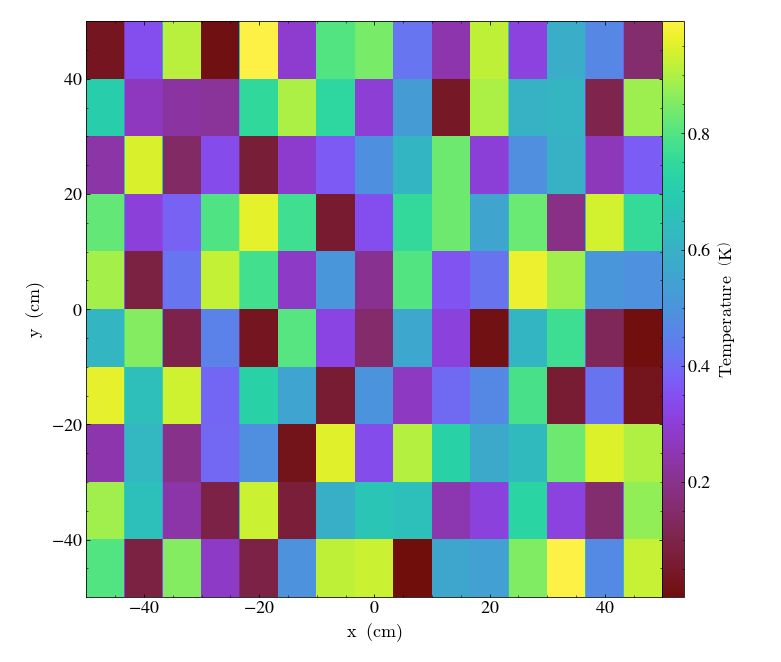

In [4]:
slc = yt.SlicePlot(yt_ds, "z", ("stream", "temperature"))
slc.set_log(("stream", "temperature"), False)
slc.show()

**Domain extent and units**

yt also has some useful attributes to quickly check the domain extents:

In [5]:
yt_ds.domain_center

unyt_array([0.5, 0.5, 0.5], 'code_length')

In [6]:
yt_ds.domain_width

unyt_array([1., 1., 1.], 'code_length')

You'll notice that the output above are `unyt` arrays. The "code_length" refers to the representative length of your volume. You can view a unyt array with different unyts with:


In [7]:
yt_ds.domain_width.to('m')

unyt_array([1., 1., 1.], 'm')


The above sample dataset sets an attribute, `geospatial_vertical_units`:

In [8]:
ds.geospatial_vertical_units

'm'

which yt_xarray sets as the dataset `length_unit`:

In [9]:
yt_ds.length_unit

unyt_quantity(1., 'm')

without this attribute, you can set it explicitly so that yt will know the dimensions of your input coordinates:

In [10]:
yt_ds = ds.yt.load_grid_from_callable(length_unit='km')

yt : [INFO     ] 2023-01-12 16:36:55,603 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-01-12 16:36:55,604 Parameters: domain_dimensions         = [15 10 15]
yt : [INFO     ] 2023-01-12 16:36:55,605 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-01-12 16:36:55,606 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-01-12 16:36:55,606 Parameters: cosmological_simulation   = 0


In [11]:
yt_ds.domain_width.to('m')

unyt_array([1000., 1000., 1000.], 'm')

for more on units, unyt and yt, you can read more [here](https://yt-project.org/doc/analyzing/units.html). 



### Loading a subset of fields

When you call `ds.yt.ds()`, it attempts to grab references to all of the available fields. If you only want to work with a subset of fields, you can use either `ds.yt.load_grid_from_callable` or `ds.yt.load_uniform_grid`. The two functions have the same arguments but differ in how they manage memory (described in more detail later in this notebooks). We'll use `load_grid_from_callable` here and simply supply the fields we want:

In [12]:
yt_ds = ds.yt.load_grid_from_callable(fields=('temperature',))

yt : [INFO     ] 2023-01-12 16:36:55,663 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-01-12 16:36:55,664 Parameters: domain_dimensions         = [15 10 15]
yt : [INFO     ] 2023-01-12 16:36:55,664 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-01-12 16:36:55,665 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-01-12 16:36:55,666 Parameters: cosmological_simulation   = 0


One of the limitations to `yt_xarray`at present is that the fields loaded into yt must have the same dimensions. 

If for example, we had a dataset with a mix of 2d and 3d and 4d (space + time) variables:


In [13]:
fields = {'temperature': ('x', 'y', 'z'), 
          'pressure': ('x', 'y', 'z'), 
          'precip': ('x', 'y', 'time'), 
          'cumulative_precip': ('x', 'y')}
dims = {'x': (0,1,14), 'y': (0, 1, 10), 'z': (0, 1, 15), 'time': (0, 1, 11)}
ds = load_random_xr_data(fields, dims, length_unit='m')

and simply try to load the full dataset with 

```
ds.yt.ds()
```
then we will get an error due to the mismatching dimensions of the variables. In this case, we can load both the temperature and pressure fields with:

In [14]:
yt_ds = ds.yt.load_grid_from_callable(fields=('temperature', 'pressure'))

yt : [INFO     ] 2023-01-12 16:36:55,728 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-01-12 16:36:55,730 Parameters: domain_dimensions         = [14 10 15]
yt : [INFO     ] 2023-01-12 16:36:55,732 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-01-12 16:36:55,733 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-01-12 16:36:55,735 Parameters: cosmological_simulation   = 0


Inferred coordinate type is cartesian -- to override, use ds.yt.set_coordinate_type


Furthermore, when loading variables with a time dimension, you should select the time index to load:

In [15]:
yt_ds = ds.yt.load_grid_from_callable(fields=('precip',), sel_dict={'time':1})

yt : [INFO     ] 2023-01-12 16:36:55,783 Parameters: current_time              = 0.1
yt : [INFO     ] 2023-01-12 16:36:55,785 Parameters: domain_dimensions         = [14 10  1]
yt : [INFO     ] 2023-01-12 16:36:55,787 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-01-12 16:36:55,788 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-01-12 16:36:55,789 Parameters: cosmological_simulation   = 0


In [16]:
value, location = yt_ds.find_min(('stream', 'precip'))

yt : [INFO     ] 2023-01-12 16:36:55,889 min value is 1.76694e-02 at 0.8928571428571428 0.2500000000000000 0.0000000000000000


### Loading method and memory usage

When you use `ds.yt.load_grid_from_callable`, yt_xarray will use references to the open xarray dataset handle internally within yt to avoid copying data. If your dataset fits into memory without a problem, then you can instead use `ds.yt.load_uniform_grid`: 

In [17]:
yt_ds = ds.yt.load_uniform_grid(fields=('temperature',))

yt : [INFO     ] 2023-01-12 16:36:55,933 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-01-12 16:36:55,934 Parameters: domain_dimensions         = [14 10 15]
yt : [INFO     ] 2023-01-12 16:36:55,934 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-01-12 16:36:55,935 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-01-12 16:36:55,935 Parameters: cosmological_simulation   = 0


and data will be copied from the xarray dataset during creation of the yt dataset.